In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from loguru import logger
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [59]:
#import tomllib
configfile = Path("../config.toml").resolve()
#with configfile.open("rb") as f:
#    config = tomllib.load(f)
config = {'raw': 'data/raw',
 'processed': 'data/processed',
 'input': 'WhatsApp_chat.txt',
 'current': 'whatsapp-20240916-104455.parq'}
datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()


if not datafile.exists():
    logger.warning("Datafile does not exist. First run src/preprocess.py, and check the timestamp!")
df = pd.read_parquet(datafile)
df.head()

,timestamp,message,author,has_emoji,is_topk,message_length,has_link,timestamp_category,hour,day_of_week,language,date,isoweek,year-week
0,2018-12-11 11:21:00,Hoi,effervescent-camel,False,True,6,False,worktimes,11:21:00,1,NL,2018-12-11,50,2018-50
1,2018-12-11 11:21:00,Kijk wat ik heb gevonden,effervescent-camel,False,True,27,False,worktimes,11:21:00,1,NL,2018-12-11,50,2018-50
2,2018-12-11 11:21:00,<Media weggelaten>,effervescent-camel,False,True,21,False,worktimes,11:21:00,1,Non-verbal,2018-12-11,50,2018-50
3,2018-12-11 11:21:00,<Media weggelaten>,effervescent-camel,False,True,21,False,worktimes,11:21:00,1,Non-verbal,2018-12-11,50,2018-50
4,2018-12-11 11:21:00,<Media weggelaten>,effervescent-camel,False,True,21,False,worktimes,11:21:00,1,Non-verbal,2018-12-11,50,2018-50


In [61]:
df['hour'] = df['timestamp'].dt.hour
df['contains_eten'] = df['message'].str.contains(r'\beten\b|\bpizza\b|\bpasta\b|\bmangia\b|\bpranzo\b|\bcena\b|\bprosciutto\b|\bkip\b|\blatte\b', case=False, regex=True)

In [62]:
df['contains_plans'] = df['message'].str.contains('vanavond|vandaag|morgen|afspraak|domani|stasera', case=False, regex=True)
df2 = df[~df[['contains_eten']].all(axis=1)]
df['contains_place'] = df2['message'].str.contains('trein|hilversum|amsterdam|thuis|huis|ik ben in', case=False, regex=True)
df3 = df2[~df2[['contains_eten']].all(axis=1)]
df['contains_people'] = df3['message'].str.contains('irene|lorenzo|papa|mama|nonno|nonna|giacomo|opa|oma', case=False, regex=True)

In [63]:
df[df['contains_eten'].fillna(False)]['hour'].value_counts().sort_index(),

(hour
 4       1
 8       4
 10      4
 11      4
 12     10
 13      6
 14      4
 15      9
 16      6
 17     20
 18    107
 19     34
 20     16
 21      2
 22      3
 23      1
 Name: count, dtype: int64,)

In [14]:
whatsapp_topics = {
    'food': df[df['contains_eten'].fillna(False)]['hour'].value_counts().sort_index(),
    'plans': df[df['contains_plans'].fillna(False)]['hour'].value_counts().sort_index(),
    'place': df[df['contains_place'].fillna(False)]['hour'].value_counts().sort_index(),
    'people': df[df['contains_people'].fillna(False)]['hour'].value_counts().sort_index(),
         }

In [28]:
hour_counts1


hour
4       1
8       5
10      4
11      4
12     10
13      6
14      4
15      9
16      6
17     20
18    107
19     34
20     16
21      2
22      3
23      1
Name: Food, dtype: int64

In [27]:

# Convert to DataFrames
hour_counts1 = pd.Series(whatsapp_topics['food'], name='Food')
hour_counts2 = pd.Series(whatsapp_topics['plans'], name='Plans')
hour_counts3 = pd.Series(whatsapp_topics['place'], name='Places')
hour_counts4 = pd.Series(whatsapp_topics['people'], name='People')


# Create a DataFrame and reindex to ensure all hours are included
df_counts = pd.DataFrame({
    #'Parents': hour_counts5,
    'Food': hour_counts1,
    'Plans': hour_counts2,
    
    'People': hour_counts4,
    'Places': hour_counts3,
    
    
    #'Mama': hour_counts5,
    #'Papa': hour_counts5,
}).fillna(0).reindex(range(24), fill_value=0)

print(df_counts)  # Check the aligned DataFrame




       Food  Plans  People  Places
hour                              
0       0.0    0.0     3.0    13.0
1       0.0    3.0     1.0     5.0
2       0.0    0.0     0.0     0.0
3       0.0    0.0     0.0     0.0
4       1.0    0.0     0.0     0.0
5       0.0    0.0     0.0     0.0
6       0.0    0.0     0.0     0.0
7       0.0    4.0     4.0     2.0
8       5.0    6.0     7.0     7.0
9       0.0   12.0     7.0     5.0
10      4.0    6.0     9.0    10.0
11      4.0    9.0     6.0    12.0
12     10.0   15.0    28.0     9.0
13      6.0    7.0    15.0    11.0
14      4.0   11.0    15.0    11.0
15      9.0   15.0    13.0    10.0
16      6.0   19.0    21.0    17.0
17     20.0   24.0    27.0    37.0
18    107.0   25.0    50.0    50.0
19     34.0   15.0    17.0    21.0
20     16.0    6.0    16.0    17.0
21      2.0    4.0    16.0     7.0
22      3.0    9.0    12.0    20.0
23      1.0   14.0     8.0    22.0


In [17]:
# Step 1: Create the DataFrame from the provided data
data = {
    'hour': list(range(24)),
    'Food': df_counts['Food'],
    'Plans': df_counts['Plans'],
    'People': df_counts['People'],
    'Places': df_counts['Places'],
}

df_counts2 = pd.DataFrame(data).fillna(0).reindex(range(24), fill_value=0)
df_counts2

,hour,Food,Plans,People,Places
hour,,,,,
0,0,0.0,0.0,3.0,13.0
1,1,0.0,3.0,1.0,5.0
2,2,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0
4,4,1.0,0.0,0.0,0.0
5,5,0.0,0.0,0.0,0.0
6,6,0.0,0.0,0.0,0.0
7,7,0.0,4.0,4.0,2.0
8,8,5.0,6.0,7.0,7.0


In [18]:

# Step 2: Melt the DataFrame for seaborn compatibility
df_melted = df_counts2.melt(id_vars='hour', var_name='Category', value_name='Value')
df_melted['%'] = df.shape[0]/df_melted['Value']*100
df_melted

,hour,Category,Value,%
0,0,Food,0.0,inf
1,1,Food,0.0,inf
2,2,Food,0.0,inf
3,3,Food,0.0,inf
4,4,Food,1.0,5.149000e+05
...,...,...,...,...
91,19,Places,21.0,2.451905e+04
92,20,Places,17.0,3.028824e+04
93,21,Places,7.0,7.355714e+04
94,22,Places,20.0,2.574500e+04


In [19]:
#df_melted[df_melted['Percentage']==100]

In [20]:
#df_melted[df_melted['Count']==117]['Normalized Count']

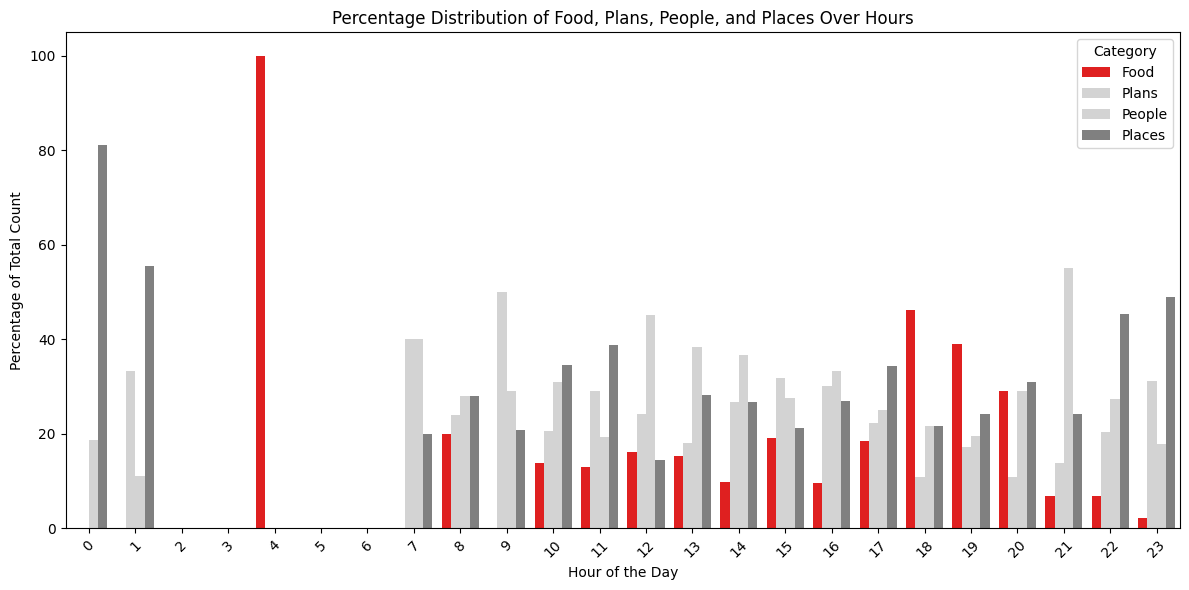

In [26]:

# Step 2: Melt the DataFrame
df_melted = pd.melt(df_counts2, id_vars=['hour'], var_name='Category', value_name='Count')

# Step 3: Calculate total counts for each hour and normalize as a percentage
df_melted['Total'] = df_melted.groupby('hour')['Count'].transform('sum')
df_melted['Percentage'] = (df_melted['Count'] / df_melted['Total']) * 100

# Step 4: Plot the percentages
colors = ['red', 'lightgray', 'lightgray', 'gray']
plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x='hour', y='Percentage', hue='Category', palette=colors)
plt.title('Percentage Distribution of Food, Plans, People, and Places Over Hours')
plt.xlabel('Hour of the Day')
plt.ylabel('Percentage of Total Count')
plt.legend(title='Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

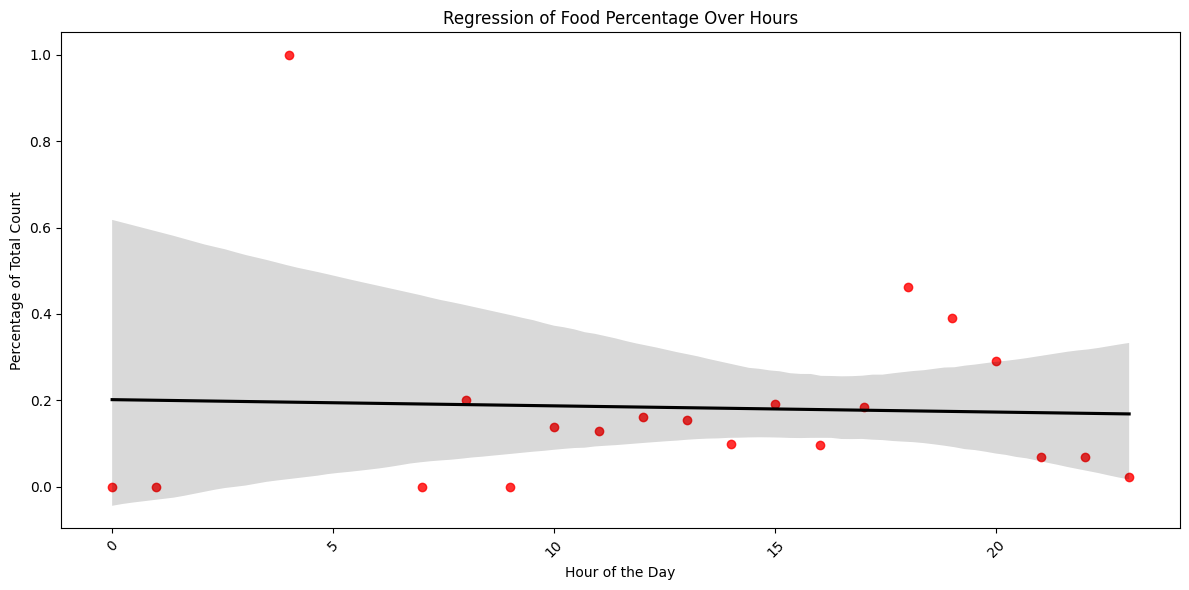

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_counts2 is defined and contains your data
# Step 2: Melt the DataFrame
df_melted = pd.melt(df_counts2, id_vars=['hour'], var_name='Category', value_name='Count')

# Step 3: Calculate total counts for each hour and normalize as a percentage
df_melted['Total'] = df_melted.groupby('hour')['Count'].transform('sum')
df_melted['Percentage'] = df_melted['Count'] / df_melted['Total'] 

# Filter for a specific category, e.g., 'Food'
df_food = df_melted[df_melted['Category'] == 'Plans']

# Step 4: Create a regplot for the 'Food' category
plt.figure(figsize=(12, 6))
sns.regplot(data=df_food, x='hour', y='Percentage', scatter_kws={'color': 'red'}, line_kws={'color': 'black'})
plt.title('Regression of Food Percentage Over Hours')
plt.xlabel('Hour of the Day')
plt.ylabel('Percentage of Total Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


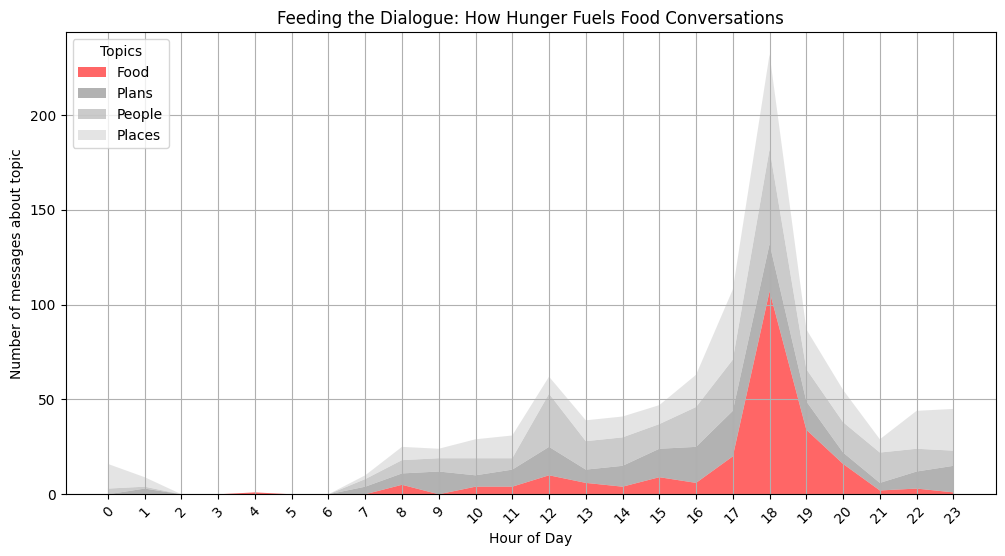

In [31]:
plt.figure(figsize=(12, 6))
# Define custom colors
colors = [  'red', 'gray', 'darkgray', 'lightgray', ]

plt.stackplot(df_counts.index, df_counts.T, colors=colors, labels=df_counts.columns, alpha=0.6)
plt.title("Feeding the Dialogue: How Hunger Fuels Food Conversations")
plt.xlabel('Hour of Day')
plt.ylabel('Number of messages about topic')
plt.xticks(df_counts.index, rotation=45)
# Add a legend with a title
plt.legend(loc='upper left', title='Topics')
plt.grid()
plt.show()

<Axes: xlabel='message_length', ylabel='Count'>

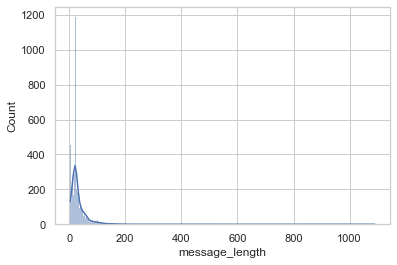

In [506]:
sns.histplot(df, x="message_length", kde=True)

<Axes: xlabel='log_len', ylabel='Count'>

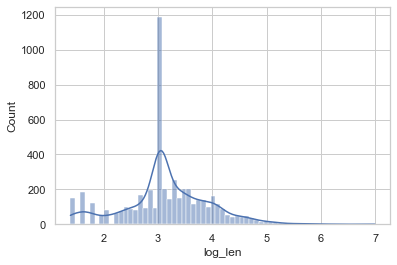

In [30]:
import numpy as np
df["log_len"] = df["message_length"].apply(lambda x: np.log(x))
sns.histplot(df, x="log_len", kde=True)

In [31]:
df

,timestamp,message,author,has_emoji,is_topk,message_length,has_link,timestamp_category,hour,day_of_week,log_len
0,2018-12-11 11:21:00,Hoi\r\n,effervescent-camel,False,True,6,False,worktimes,11:21:00,1,1.791759
1,2018-12-11 11:21:00,Kijk wat ik heb gevonden\r\n,effervescent-camel,False,True,27,False,worktimes,11:21:00,1,3.295837
2,2018-12-11 11:21:00,<Media weggelaten>\r\n,effervescent-camel,False,True,21,False,worktimes,11:21:00,1,3.044522
3,2018-12-11 11:21:00,<Media weggelaten>\r\n,effervescent-camel,False,True,21,False,worktimes,11:21:00,1,3.044522
4,2018-12-11 11:21:00,<Media weggelaten>\r\n,effervescent-camel,False,True,21,False,worktimes,11:21:00,1,3.044522
...,...,...,...,...,...,...,...,...,...,...,...
5144,2024-07-04 03:20:00,Verder alles goed!\r\n,effervescent-camel,False,True,21,False,night,03:20:00,3,3.044522
5145,2024-07-04 07:25:00,https://www.udinetoday.it/cronaca/navetta-gra...,nimble-wombat,False,True,64,True,morning,07:25:00,3,4.158883
5146,2024-07-04 13:59:00,<Media weggelaten>\r\n,hilarious-goldfinch,False,True,21,False,worktimes,13:59:00,3,3.044522
5147,2024-07-04 14:14:00,<Media weggelaten>\r\n,nimble-wombat,False,True,21,False,worktimes,14:14:00,3,3.044522


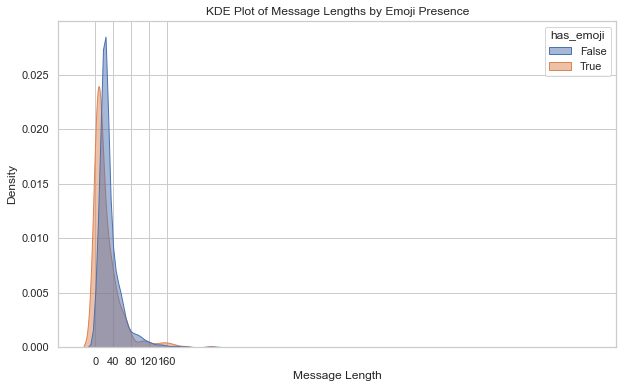

In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Sample data
data = {
    'message_length': df['message_length'],
    'has_emoji': df['has_emoji']
}
df = pd.DataFrame(data)

# Set the style
sns.set(style="whitegrid")

# Create the KDE plot
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='message_length', hue='has_emoji', fill=True, common_norm=False, alpha=0.5)
plt.title('KDE Plot of Message Lengths by Emoji Presence')
plt.xlabel('Message Length')
plt.ylabel('Density')
plt.xticks(range(0, 200, 40))  # Adjust x-ticks as necessary
plt.show()

<Figure size 864x432 with 0 Axes>

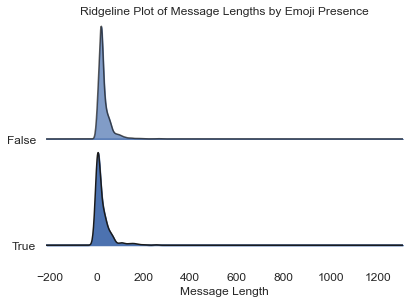

In [104]:
from joypy import joyplot

# Sample data
data = {
    'message_length': df['message_length'],
    'has_emoji': df['has_emoji']
}
df = pd.DataFrame(data)

# Create the ridgeline plot
plt.figure(figsize=(12, 6))
joyplot(
    data=df, 
    by='has_emoji', 
    column='message_length',
    fade=True,
    overlap=0.5
)
plt.title('Ridgeline Plot of Message Lengths by Emoji Presence')
plt.xlabel('Message Length')
plt.ylabel('Density')
plt.show()

In [105]:
df

,message_length,has_emoji
0,6,False
1,27,False
2,21,False
3,21,False
4,21,False
...,...,...
5144,21,False
5145,64,False
5146,21,False
5147,21,False


<Figure size 1200x600 with 0 Axes>

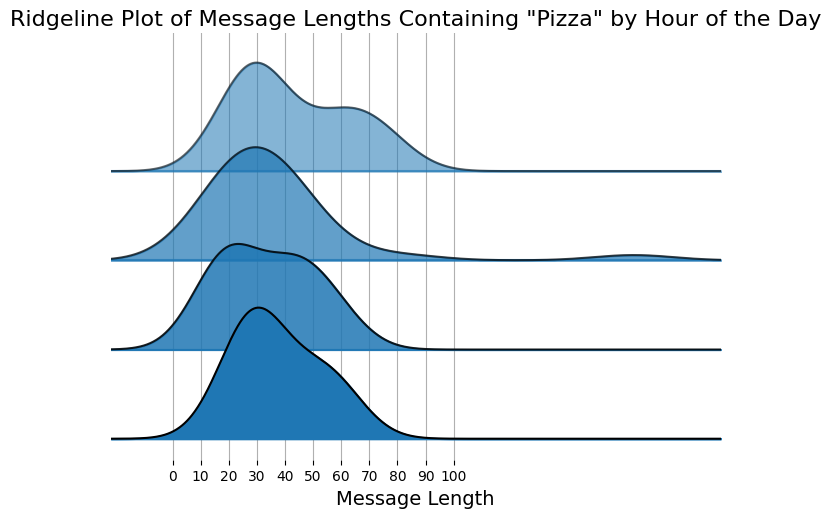

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joypy import joyplot


# Extract hour from timestamp and categorize it
df['hour'] = df['timestamp'].dt.hour
df['contains_pizza'] = df['message'].str.contains('pizza', case=False)

# Filter data for only the rows that contain 'pizza'
pizza_df = df[df['contains_pizza']]

# Prepare data for the ridgeline plot
pizza_data = []
for hour in range(24):
    lengths = pizza_df[pizza_df['hour'] == hour]['message'].str.len()
    if len(lengths) > 1:  # Ensure variability
        pizza_data.append(lengths)

# Create the ridgeline plot only if there is data
if pizza_data:
    plt.figure(figsize=(12, 6))
    joyplot(data=pizza_data, fade=True, overlap=1, linewidth=1.5)
    plt.title('Ridgeline Plot of Message Lengths Containing "Pizza" by Hour of the Day', fontsize=16)
    plt.xlabel('Message Length', fontsize=14)
    plt.ylabel('Hour of Day', fontsize=14)
    plt.xticks(range(0, 110, 10))  # Set x-ticks as needed
    plt.grid(visible=True)
    plt.show()
else:
    print("No sufficient data to create a ridgeline plot.")


In [91]:
hour_counts = pizza_df['hour'].value_counts().sort_index()
print("Counts of messages containing 'pizza' by hour:")
print(hour_counts)

Counts of messages containing 'pizza' by hour:
12     1
13     1
15     1
17    10
18    30
19     6
20     3
Name: hour, dtype: int64


In [49]:
# Sample data creation
np.random.seed(0)
# Extract hour from timestamp and categorize it

# Extract hour from timestamp and categorize it
df['hour'] = df['timestamp'].dt.hour

# Create separate DataFrames for each word
pizza_df = df[df['message'].str.contains('pizza', case=False)]
leuk_df = df[df['message'].str.contains('leuk', case=False)]

# Prepare data for the ridgeline plot
pizza_data = []
leuk_data = []

# Filter messages containing the word 'pizza'
pizza_df = df[df['message'].str.contains('pizza', case=False)]

# Prepare data for the ridgeline plot
pizza_data = []

# Collect message lengths for each hour
for hour in range(24):
    message_lengths = len(pizza_df[pizza_df['hour'] == hour])
    if len(message_lengths) > 0:
        pizza_data.append(message_lengths.values)

# Create a figure for the ridgeline plot
plt.figure(figsize=(12, 6))

# Plotting the ridgeline for the word "pizza"
joyplot(data=pizza_data, fade=True, overlap=0, linewidth=1.5, color='blue')

# Set the title and labels
plt.title('Ridgeline Plot of Message Lengths Containing "Pizza" by Hour of the Day', fontsize=16)
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Message Length Distribution', fontsize=14)

# Set custom y-ticks for the word
plt.yticks([0], ['Pizza'])  # Only one word in this case

# Set x-ticks to show hours
plt.xticks(range(24))

plt.grid(visible=True)
plt.show()

TypeError: object of type 'int' has no len()

<Figure size 1200x600 with 0 Axes>

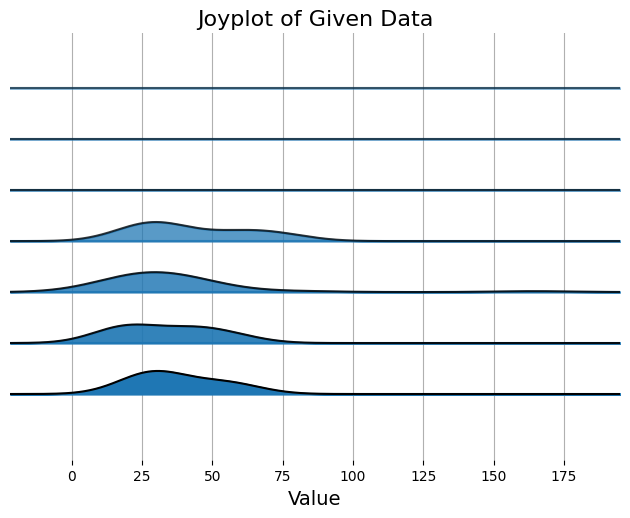

In [50]:
# Provided data
data = [
    np.array([36], dtype=int),
    np.array([72], dtype=int),
    np.array([58], dtype=int),
    np.array([35, 60, 27, 69, 55, 24, 32, 26, 75, 30], dtype=int),
    np.array([28, 24, 45, 25, 164, 31, 16, 16, 30, 81, 29, 38, 9, 16, 45, 28, 17, 47, 18, 28, 55, 24, 48, 32, 40, 37, 16, 35, 40, 30], dtype=int),
    np.array([57, 43, 24, 19, 43, 16], dtype=int),
    np.array([55, 28, 30], dtype=int),
]
# Create a figure for the joyplot
plt.figure(figsize=(12, 6))

# Plot the joyplot
joyplot(data=data, fade=True, overlap=1, linewidth=1.5)

# Set the title and labels
plt.title('Joyplot of Given Data', fontsize=16)
plt.xlabel('Value', fontsize=14)
plt.ylabel('Group', fontsize=14)

# Set y-ticks to label the groups
plt.yticks(range(len(data)), [f'Group {i+1}' for i in range(len(data))])

plt.grid(visible=True)
plt.show()

C:\Users\Francesca\AppData\Local\Temp\ipykernel_25704\3416345577.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pizza_df['message_length'] = pizza_df['message'].str.len()


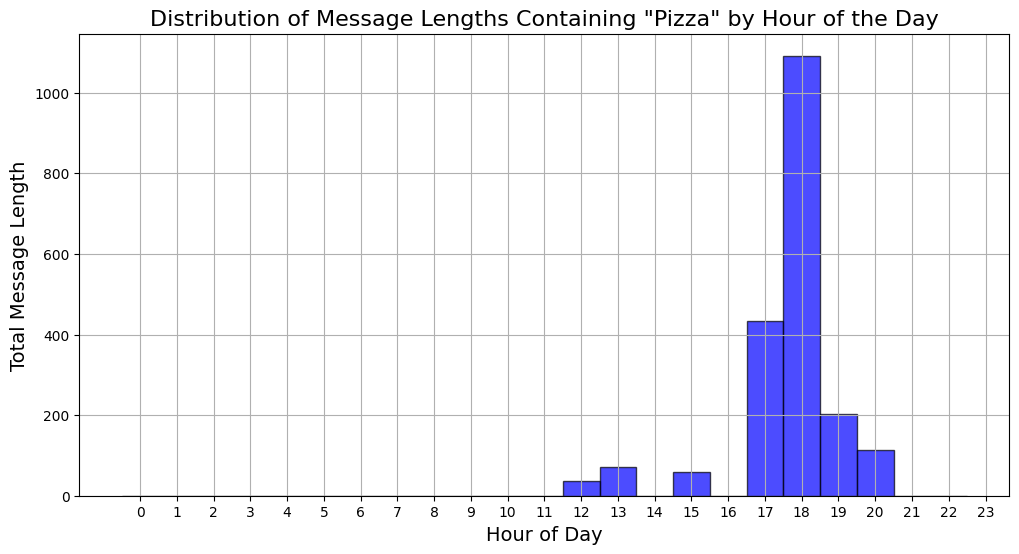

In [51]:

# Extract hour from timestamp
df['hour'] = df['timestamp'].dt.hour

# Filter messages containing the word 'pizza'
pizza_df = df[df['message'].str.contains('pizza', case=False)]

# Calculate message lengths
pizza_df['message_length'] = pizza_df['message'].str.len()

# Create the plot
plt.figure(figsize=(12, 6))

# Plotting the distribution of message lengths by hour
plt.hist(
    pizza_df['hour'],
    weights=pizza_df['message_length'],
    bins=np.arange(24) - 0.5,  # Center the bars on the hour
    alpha=0.7, color='blue', 
    edgecolor='black'
)

# Set the title and labels
plt.title('Distribution of Message Lengths Containing "Pizza" by Hour of the Day', fontsize=16)
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Total Message Length', fontsize=14)

# Set x-ticks to show hours
plt.xticks(range(24))

plt.grid(visible=True)
plt.show()

c:\installaties\miniconda3\lib\site-packages\joypy\joyplot.py:286: UserWarning: The data contains a group with a single distinct value (12) having infinite probability density. Consider using a different visualization.
  warnings.warn("The data contains a group with a single distinct value ({}) "


<Figure size 864x432 with 0 Axes>

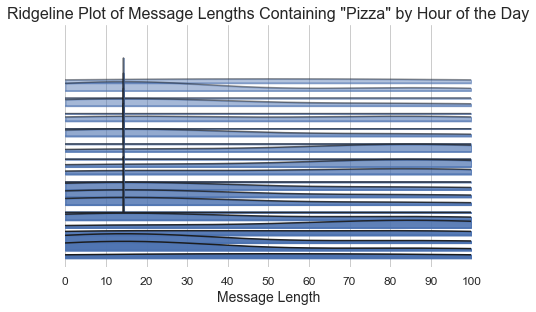

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joypy import joyplot

# Sample data creation
np.random.seed(0)
data = {
    'timestamp': pd.date_range(start='2024-01-01', periods=200, freq='H'),
    'message': np.random.choice(['I want pizza', 'Let’s order sushi', 'Pizza sounds great', 
                                  'I love pasta', 'What about burgers?', 'Pizza again?'], 200),
}

# Create a DataFrame
df = pd.DataFrame(data)

# Extract hour from timestamp and categorize it
df['hour'] = df['timestamp'].dt.hour
df['contains_pizza'] = df['message'].str.contains('pizza', case=False)

# Filter data for only the rows that contain 'pizza'
pizza_df = df[df['contains_pizza']]

# Prepare data for the ridgeline plot
pizza_data = []
for hour in range(24):
    # Get message lengths for each hour
    lengths = pizza_df[pizza_df['hour'] == hour]['message'].str.len()
    if len(lengths) > 1:  # Ensure there's variability
        pizza_data.append(lengths.values)

# Debug: Check if pizza_data is empty
if not pizza_data:
    print("No sufficient data to create a ridgeline plot. Check the filtering criteria.")
else:
    # Create the ridgeline plot
    plt.figure(figsize=(12, 6))
    joyplot(data=pizza_data, fade=True, overlap=1, linewidth=1.5)
    plt.title('Ridgeline Plot of Message Lengths Containing "Pizza" by Hour of the Day', fontsize=16)
    plt.xlabel('Message Length', fontsize=14)
    plt.ylabel('Hour of Day', fontsize=14)
    plt.xticks(range(0, 110, 10))  # Set x-ticks as needed
    plt.grid(visible=True)
    plt.show()


Text(0.5, 1.0, 'Wanneer zijn berichten langer?')

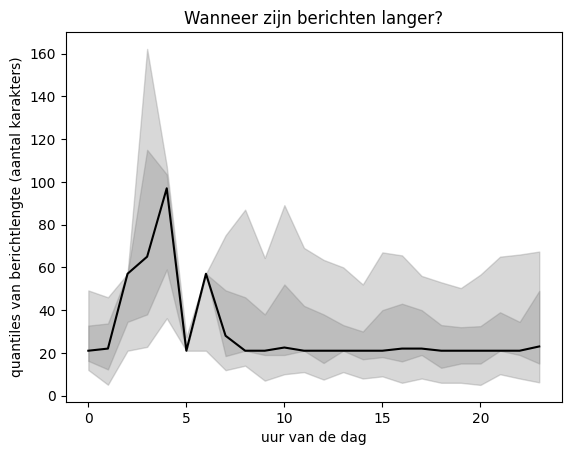

In [52]:
q1 = lambda x: np.quantile(x, 0.1)
q2 = lambda x: np.quantile(x, 0.25)
q3 = lambda x: np.quantile(x, 0.5)
q4 = lambda x: np.quantile(x, 0.75)
q5 = lambda x: np.quantile(x, 0.9)

df["hour"] = df.timestamp.dt.hour
quantiles = df.groupby('hour')['message_length'].agg([q1, q2, q3, q4, q5])
quantiles.columns = ['q1', 'q2', 'q3', 'q4', 'q5']
p = quantiles.reindex(range(24), fill_value=0)

plt.plot(p.index, p["q3"], color="black")
plt.fill_between(p.index, p["q2"], p["q4"], color="grey", alpha=0.3)
plt.fill_between(p.index, p["q1"], p["q5"], color="grey", alpha=0.3)
plt.xlabel("uur van de dag")
plt.ylabel("quantiles van berichtlengte (aantal karakters)")
plt.title("Wanneer zijn berichten langer?")

<Figure size 1200x600 with 0 Axes>

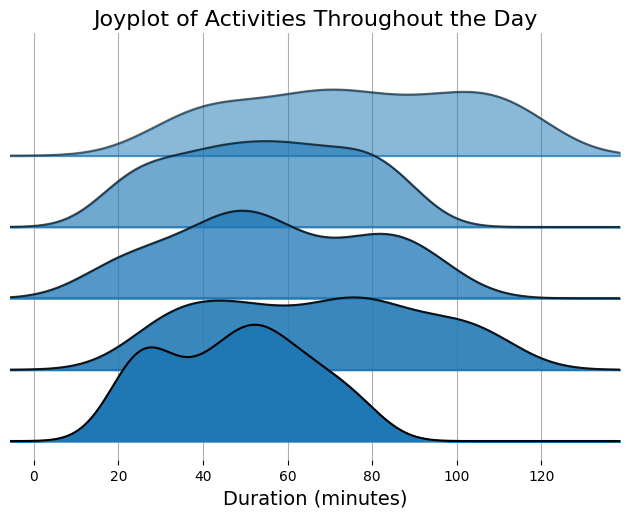

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joypy import joyplot

# Sample data generation
np.random.seed(0)

# Generate data for different activities throughout the day (0-23 hours)
activities = {
    'Running': np.random.randint(30, 120, 100),  # Random durations between 30 and 120 minutes
    'Yoga': np.random.randint(20, 90, 100),
    'Sport': np.random.randint(15, 100, 100),
    'Cycling': np.random.randint(25, 110, 100),
    'Swimming': np.random.randint(20, 80, 100),
}

# Create a DataFrame
df = pd.DataFrame(activities)

# Prepare data for the joyplot
data = []
for activity in activities.keys():
    activity_data = df[activity].values
    data.append(activity_data)

# Create a figure for the joyplot
plt.figure(figsize=(12, 6))

# Plotting the joyplot
joyplot(data=data, fade=True, overlap=1, linewidth=1.5)

# Set the title and labels
plt.title('Joyplot of Activities Throughout the Day', fontsize=16)
plt.xlabel('Duration (minutes)', fontsize=14)
plt.ylabel('Activities', fontsize=14)

# Set y-ticks to show activity names
plt.yticks(range(len(activities)), list(activities.keys()))

plt.grid(visible=True)
plt.show()


<Figure size 1200x600 with 0 Axes>

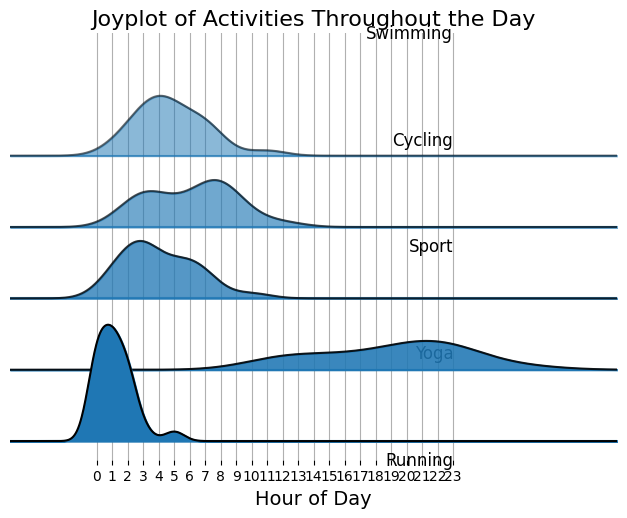

In [54]:
# Define the hours of the day (0-23)
hours = np.arange(24)

# Generate random counts for activities at different hours
activities = {
    'Running': np.random.poisson(5, 24),  # Random counts using Poisson distribution
    'Yoga': np.random.poisson(6, 24),
    'Sport': np.random.poisson(4, 24),
    'Cycling': np.random.poisson(20, 24),
    'Swimming': np.random.poisson(1, 24),
}

# Create a DataFrame
df = pd.DataFrame(activities, index=hours)

# Prepare data for the joyplot
data = []
for activity in activities.keys():
    activity_data = df[activity].values
    data.append(activity_data)

# Create a figure for the joyplot
plt.figure(figsize=(12, 6))

# Plotting the joyplot
joyplot(data=data, fade=True, overlap=1, linewidth=1.5)

# Set the title and labels
plt.title('Joyplot of Activities Throughout the Day', fontsize=16)
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Activity', fontsize=14)

# Set y-ticks to show activity names
plt.yticks(range(len(activities)), list(activities.keys()))

# Add labels to each ridge
for i, activity in enumerate(activities.keys()):
    plt.text(x=23, y=i, s=activity, fontsize=12, va='center', ha='right', color='black')


# Set x-ticks to show hours
plt.xticks(hours)

plt.grid(visible=True)
plt.show()


In [64]:
import re
from collections import defaultdict

most_common_words_NL = []
most_common_words_IT = []
# Function to preprocess text
def preprocess_text(text, most_common_words):
    # Remove punctuation and convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    
    # Tokenize the messages into words
    words = text.split()
    
    for word in words:
        if word not in dutch_stopwords and word not in italian_stopwords:
            # Update the count for each word in the dictionary
            most_common_words[word] += 1

    return most_common_words


df_dutch = df[df['language']=='NL']['message']
df_italian = df[df['language']=='IT']['message']
df_all = df[df['language'].isin(['NL', 'IT'])]['message']

# Apply preprocessing to the 'message' column
most_common_words_NL = defaultdict(int)  # Initialize as a defaultdict to handle missing keys 
most_common_words_IT = defaultdict(int)
most_common_words_all = defaultdict(int)            
df_dutch.apply(lambda x: preprocess_text(x, most_common_words_NL))
df_italian.apply(lambda x: preprocess_text(x, most_common_words_IT))
df_all.apply(lambda x: preprocess_text(x, most_common_words_all))


NameError: name 'dutch_stopwords' is not defined

In [246]:
word_counts_all = Counter(most_common_words_all)
word_counts_all.most_common(50)

[('eten', 120),
 ('thuis', 114),
 ('mee', 112),
 ('kom', 104),
 ('eet', 100),
 ('goed', 91),
 ('ga', 75),
 ('vanavond', 72),
 ('ok', 72),
 ('laat', 63),
 ('irene', 62),
 ('mama', 60),
 ('gaan', 59),
 ('lorenzo', 58),
 ('huis', 49),
 ('papa', 49),
 ('nee', 49),
 ('morgen', 48),
 ('leuk', 47),
 ('vandaag', 47),
 ('lekker', 44),
 ('gaat', 44),
 ('komen', 41),
 ('bericht', 41),
 ('zit', 39),
 ('pizza', 38),
 ('hilversum', 38),
 ('denk', 35),
 ('willen', 35),
 ('kip', 35),
 ('halen', 35),
 ('uur', 34),
 ('slapen', 33),
 ('verwijderd', 31),
 ('hoor', 30),
 ('31683842928', 30),
 ('amsterdam', 30),
 ('31615674612', 29),
 ('blijf', 27),
 ('mooi', 27),
 ('kun', 27),
 ('maken', 27),
 ('heel', 26),
 ('kijken', 26),
 ('trein', 26),
 ('2', 25),
 ('1', 24),
 ('bellen', 24),
 ('doe', 24),
 ('echt', 23)]

In [247]:
word_counts_NL = Counter(most_common_words_NL)
word_counts_NL.most_common(50)


[('eten', 120),
 ('thuis', 114),
 ('mee', 111),
 ('kom', 104),
 ('eet', 100),
 ('goed', 88),
 ('ga', 75),
 ('vanavond', 72),
 ('ok', 68),
 ('laat', 62),
 ('mama', 59),
 ('gaan', 58),
 ('irene', 56),
 ('huis', 49),
 ('papa', 48),
 ('nee', 48),
 ('morgen', 48),
 ('leuk', 47),
 ('lorenzo', 47),
 ('vandaag', 47),
 ('lekker', 43),
 ('gaat', 43),
 ('komen', 41),
 ('bericht', 41),
 ('zit', 39),
 ('hilversum', 36),
 ('denk', 35),
 ('willen', 35),
 ('pizza', 35),
 ('halen', 35),
 ('uur', 34),
 ('slapen', 33),
 ('verwijderd', 31),
 ('hoor', 29),
 ('kip', 29),
 ('31683842928', 29),
 ('amsterdam', 29),
 ('31615674612', 28),
 ('blijf', 27),
 ('mooi', 27),
 ('kun', 27),
 ('maken', 27),
 ('heel', 26),
 ('kijken', 26),
 ('trein', 26),
 ('bellen', 24),
 ('doe', 24),
 ('1', 23),
 ('nodig', 23),
 ('2', 23)]

In [65]:
pizza_df['hour'].value_counts().sort_index()

hour
12     1
13     1
15     1
17    10
18    30
19     6
20     3
Name: count, dtype: int64

In [66]:
df[df['contains_eten']]['hour'].value_counts().sort_index()

hour
4       1
8       4
10      4
11      4
12     10
13      6
14      4
15      9
16      6
17     20
18    107
19     34
20     16
21      2
22      3
23      1
Name: count, dtype: int64

In [67]:
# Extract hour from timestamp and categorize it


In [68]:
df['hour'] = df['timestamp'].dt.hour
df['contains_eten'] = df['message'].str.contains('eten|eet|pizza|pasta|mangia|pranzo|cena|prosciutto|kip|latte', case=False, regex=True)
df['contains_plans'] = df['message'].str.contains('vanavond|vandaag|morgen|afspraak|domani|stasera', case=False, regex=True)
df['contains_place'] = df['message'].str.contains('trein|hilversum|amsterdam|thuis|huis|ik ben in', case=False, regex=True)
df['contains_people'] = df['message'].str.contains('irene|lorenzo|papa|mama|nonno|nonna|giacomo', case=False, regex=True)
df['contains_parents'] = df['message'].str.contains('papa|mama|nonno|nonna', case=False, regex=True)
whatsapp_topics = {
    'food': df[df['contains_eten']]['hour'].value_counts().sort_index(),
    'plans': df[df['contains_plans']]['hour'].value_counts().sort_index(),
    'place': df[df['contains_place']]['hour'].value_counts().sort_index(),
    'people': df[df['contains_people']]['hour'].value_counts().sort_index(),
    'parents':df[df['contains_parents']]['hour'].value_counts().sort_index(),
         }

<Figure size 1200x600 with 0 Axes>

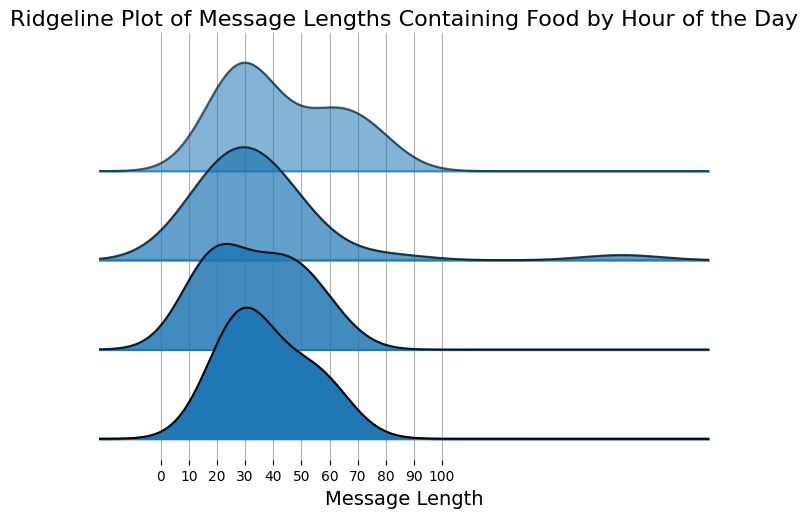

In [69]:
# Filter data for only the rows that contain 'pizza'
eten_df = df[df['contains_eten']]

# Prepare data for the ridgeline plot
eten_data = []
for hour in range(24):
    # Get message lengths for each hour
    lengths = pizza_df[pizza_df['hour'] == hour]['message'].str.len()
    if len(lengths) > 1:  # Ensure there's variability
        pizza_data.append(lengths.values)

# Debug: Check if pizza_data is empty
if not pizza_data:
    print("No sufficient data to create a ridgeline plot. Check the filtering criteria.")
else:
    # Create the ridgeline plot
    plt.figure(figsize=(12, 6))
    joyplot(data=pizza_data, fade=True, overlap=1, linewidth=1.5)
    plt.title('Ridgeline Plot of Message Lengths Containing Food by Hour of the Day', fontsize=16)
    plt.xlabel('Message Length', fontsize=14)
    plt.ylabel('Hour of Day', fontsize=14)
    plt.xticks(range(0, 110, 10))  # Set x-ticks as needed
    plt.grid(visible=True)
    plt.show()

[  8. 162.  26.   8.   4.  20.   9.   4.   8.   8.  18.   6.  58.  18.
  10.   1.   0.   2.  54.   1.   0.   0.   0.   0.]
[ 9. 25.  6.  6. 12. 19.  4. 14.  9. 11. 15.  6. 15. 15.  7.  0.  0.  4.
 24.  3.  0.  0.  0.  0.]
[12. 58. 18. 10.  5. 17.  8. 22. 20. 11. 11.  7. 22.  9. 11.  0.  0.  2.
 38.  5. 13.  0.  0.  0.]
[ 6. 52. 16.  8.  7. 21. 16.  8. 10. 13. 12.  6. 18. 28. 16.  0.  0.  2.
 25.  1.  3.  0.  0.  0.]


<Figure size 1200x600 with 0 Axes>

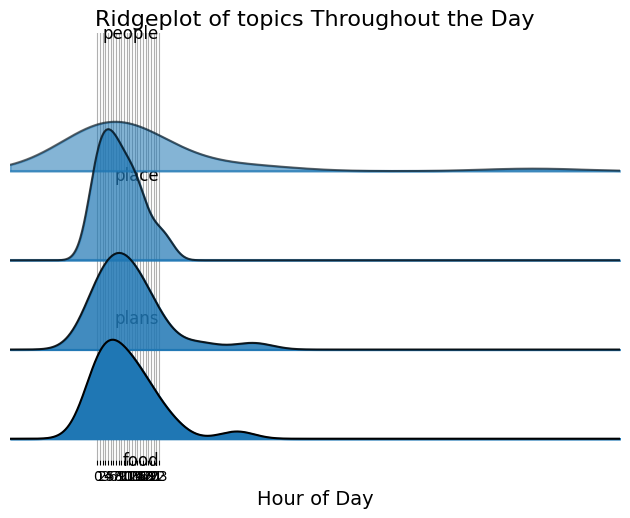

In [70]:
# Create a timeline (e.g., hours of the day)
hours = df['hour'].unique()

# Generate sample data for different activities at different times


whatsapp_topics = {
    'food': df[df['contains_eten']]['hour'].fillna(0).value_counts(dropna=True).sort_index(),
    'plans': df[df['contains_plans']]['hour'].fillna(0).value_counts(dropna=True).sort_index(),
    'place': df[df['contains_place']]['hour'].fillna(0).value_counts(dropna=True).sort_index(),
    'people': df[df['contains_people']]['hour'].fillna(0).value_counts(dropna=True).sort_index(),
         }
# Create a DataFrame
df_topics = pd.DataFrame(whatsapp_topics, index=hours)

# Prepare data for the joyplot
data = []
for topic in whatsapp_topics.keys():
    print(df_topics[topic].fillna(0).values)
    topic_data = df_topics[topic].fillna(0).values
    data.append(topic_data)

# Create a figure for the joyplot
plt.figure(figsize=(12, 6))

# Plotting the joyplot
joyplot(data=data, fade=True, overlap=1, linewidth=1.5)

# Set the title and labels
plt.title('Ridgeplot of topics Throughout the Day', fontsize=16)
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Topic', fontsize=14)

# Add labels to each ridge
for i, topic in enumerate(whatsapp_topics.keys()):
    plt.text(x=23, y=i, s=topic, fontsize=12, va='center', ha='right', color='black')


# Set y-ticks to show activity names
plt.yticks(range(len(whatsapp_topics)), list(whatsapp_topics.keys()))

# Set x-ticks to show hours
plt.xticks(hours)

plt.grid(visible=True)
plt.show()

<Axes: xlabel='hour', ylabel='Count'>

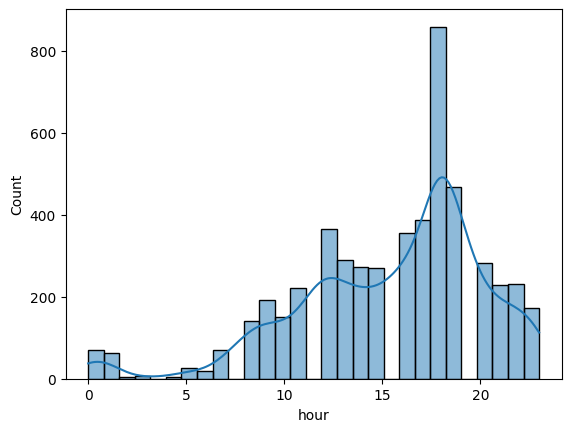

In [71]:
sns.histplot(whatsapp_topics, x=df["hour"], kde=True)

In [76]:
df[df['contains_eten']]

,timestamp,message,author,has_emoji,is_topk,message_length,has_link,timestamp_category,hour,day_of_week,language,date,isoweek,year-week,contains_eten,contains_plans,contains_place,contains_people,contains_parents
7,2019-02-14 18:40:00,Hoi is het goed als ik bij Siem blijf eten,effervescent-camel,False,True,45,False,evening,18,3,NL,2019-02-14,7,2019-06,True,False,False,False,False
15,2019-03-16 20:06:00,Cosa mangiate,nimble-wombat,False,True,17,False,evening,20,5,IT,2019-03-16,11,2019-10,True,False,False,False,False
17,2019-03-16 20:06:00,Dobbiamo portare una pizza per Lorenzo Chiedig...,nimble-wombat,False,True,55,False,evening,20,5,IT,2019-03-16,11,2019-10,True,False,False,True,False
19,2019-03-16 20:07:00,Lorenzo ha mangiato,nimble-wombat,False,True,23,False,evening,20,5,IT,2019-03-16,11,2019-10,True,False,False,True,False
82,2019-05-06 15:26:00,Weet je heel zeker dat niemand iets tegen opa ...,effervescent-camel,False,True,69,False,worktimes,15,0,NL,2019-05-06,19,2019-18,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4957,2024-06-08 19:16:00,Zullen we eten voor ons bestellen vanavond,effervescent-camel,False,True,46,False,evening,19,5,NL,2024-06-08,23,2024-23,True,True,False,False,False
4958,2024-06-08 19:42:00,Nee we maken pasta met sugo,nimble-wombat,False,True,30,False,evening,19,5,NL,2024-06-08,23,2024-23,True,False,False,False,False
4961,2024-06-08 19:53:00,Eet je mee,nimble-wombat,False,True,14,False,evening,19,5,NL,2024-06-08,23,2024-23,True,False,False,False,False
5028,2024-06-16 12:14:00,ziet er heel gek uit! die pizza's,nimble-wombat,False,True,36,False,worktimes,12,6,NL,2024-06-16,24,2024-24,True,False,False,False,False


<Figure size 2000x1000 with 0 Axes>

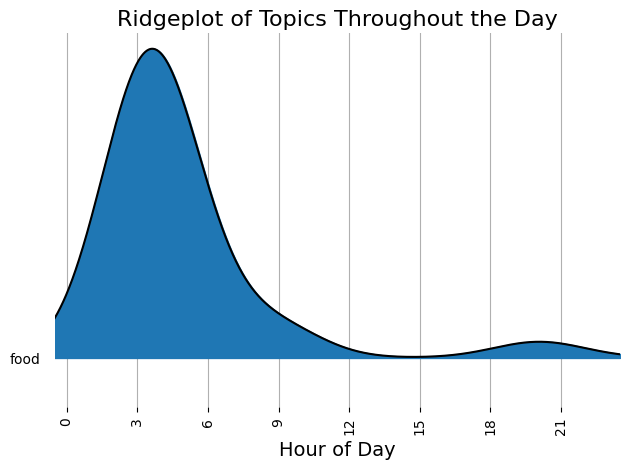

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joypy import joyplot

# Sample DataFrame creation (replace this with your actual DataFrame)
# df = pd.read_csv('your_data.csv')  # Load your data

# Create a timeline (e.g., hours of the day)
hours = np.arange(24)  # Assuming hours are 0-23

# Generate sample data for different activities at different times
whatsapp_topics = {
    'food': df[df['contains_eten']]['hour'].value_counts().reindex(hours, fill_value=0),
   # 'plans': df[df['contains_plans']]['hour'].value_counts().reindex(hours, fill_value=0),
   # 'place': df[df['contains_place']]['hour'].value_counts().reindex(hours, fill_value=0),
   # 'people': df[df['contains_people']]['hour'].value_counts().reindex(hours, fill_value=0),
}

# Create a DataFrame
df_topics = pd.DataFrame(whatsapp_topics)

# Prepare data for the joyplot
data = []
for topic in whatsapp_topics.keys():
    topic_data = df_topics[topic].values
    data.append(topic_data)

# Create a figure for the joyplot with increased width
plt.figure(figsize=(20, 10))  # Increase the width and height

# Plotting the joyplot with adjustments
joyplot(data=df_topics, fade=True, overlap=0.5, linewidth=1.5)

# Set the title and labels
plt.title('Ridgeplot of Topics Throughout the Day', fontsize=16)
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Topic', fontsize=14)

# Add labels to each ridge
#for i, topic in enumerate(whatsapp_topics.keys()):
#    plt.text(x=23, y=i, s=topic, fontsize=12, va='center', ha='right', color='black')

# Set y-ticks to show topic names
plt.yticks(range(len(whatsapp_topics)), list(whatsapp_topics.keys()))

# Set x-ticks to show hours with a rotation for better readability
plt.xticks(np.arange(0, 24, 3), rotation=90)  # Display every hour

# Set x-axis limits for better spacing
plt.xlim(-0.5, 23.5)

plt.grid(visible=True)
plt.tight_layout()  # Adjust layout for better spacing
plt.show()


In [358]:
np.arange(0, 24, 3)

array([ 0,  3,  6,  9, 12, 15, 18, 21])

In [77]:
df[df['contains_eten']]['hour'].value_counts().reindex(hours, fill_value=0)

hour
0       0
1       1
2       0
3       0
4       1
5       0
6       0
7       2
8       6
9       4
10      8
11      8
12     18
13     10
14      8
15     18
16     20
17     54
18    162
19     58
20     26
21      9
22      8
23      4
Name: count, dtype: int64

<Figure size 1200x600 with 0 Axes>

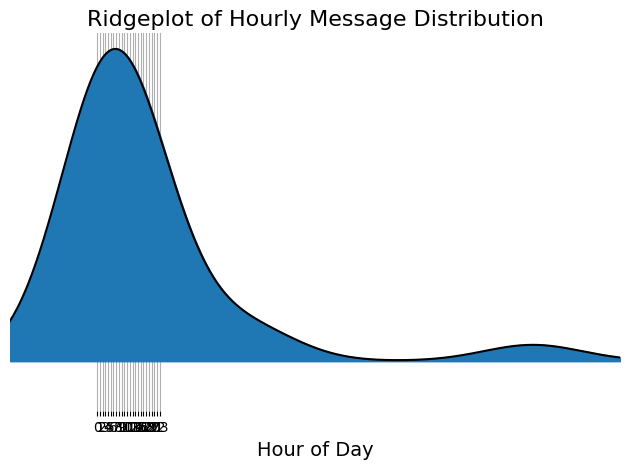

In [78]:
data = {
    0: 0, 1: 1, 2: 0, 3: 0, 4: 1,
    5: 0, 6: 0, 7: 2, 8: 6, 9: 4,
    10: 8, 11: 8, 12: 18, 13: 10,
    14: 8, 15: 17, 16: 20, 17: 53,
    18: 160, 19: 58, 20: 26, 21: 9,
    22: 8, 23: 4
}

# Convert to DataFrame
hour_counts = pd.Series(data)

# Prepare data for the joyplot
# Since we need to create a ridgeline, we'll replicate the counts for a single topic
data_for_plot = [hour_counts.values]  # Wrapping it in a list for joyplot

# Create a figure for the joyplot
plt.figure(figsize=(12, 6))

# Plotting the joyplot
joyplot(data=data_for_plot, fade=True, overlap=0.5, linewidth=1.5)

# Set the title and labels
plt.title('Ridgeplot of Hourly Message Distribution', fontsize=16)
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Set y-ticks to show only one topic since we have one set of data
plt.yticks([0], ['Messages'])

# Set x-ticks to show hours
plt.xticks(range(24))

plt.grid(visible=True)
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

<Figure size 1600x800 with 0 Axes>

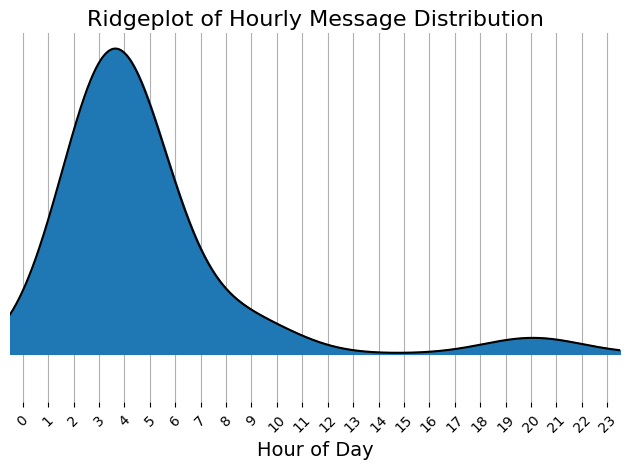

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joypy import joyplot

# Provided hour distribution data
data = {
    0: 0, 1: 1, 2: 0, 3: 0, 4: 1,
    5: 0, 6: 0, 7: 2, 8: 6, 9: 4,
    10: 8, 11: 8, 12: 18, 13: 10,
    14: 8, 15: 17, 16: 20, 17: 53,
    18: 160, 19: 58, 20: 26, 21: 9,
    22: 8, 23: 4
}

# Convert to DataFrame
hour_counts = pd.Series(data)

# Prepare data for the joyplot
# Replicate the counts for a single topic
data_for_plot = [hour_counts.values]  # Single distribution for joyplot

# Create a figure for the joyplot
plt.figure(figsize=(16, 8))  # Wider figure for better visibility

# Plotting the joyplot
joyplot(data=data_for_plot, fade=True, overlap=0.5, linewidth=1.5)

# Set the title and labels
plt.title('Ridgeplot of Hourly Message Distribution', fontsize=16)
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Set y-ticks to show only one topic since we have one set of data
plt.yticks([0], ['Messages'])

# Set x-ticks to show hours, adjust the range and rotation for better visibility
plt.xticks(range(24), rotation=45)

# Set the x-axis limit to improve clarity
plt.xlim(-0.5, 23.5)

plt.grid(visible=True)
plt.tight_layout()  # Adjust layout for better spacing
plt.show()


In [363]:
data_for_plot

[array([  0,   1,   0,   0,   1,   0,   0,   2,   6,   4,   8,   8,  18,
         10,   8,  17,  20,  53, 160,  58,  26,   9,   8,   4], dtype=int64)]

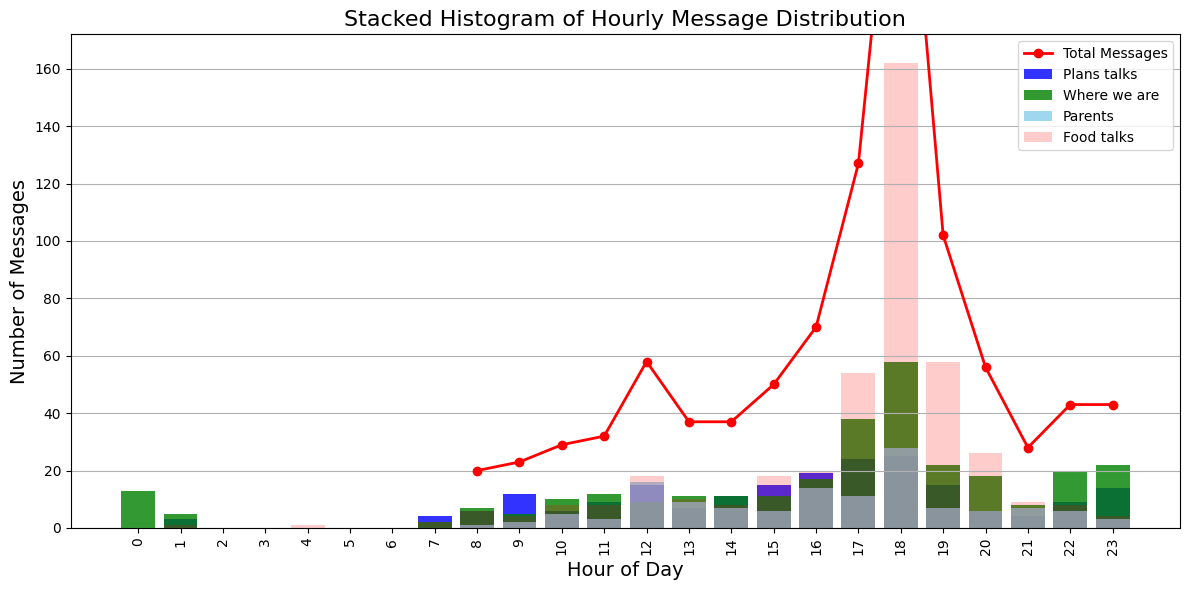

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

whatsapp_topics = {
    'food': df[df['contains_eten']]['hour'].value_counts().sort_index(),
    'plans': df[df['contains_plans']]['hour'].value_counts().sort_index(),
    'place': df[df['contains_place']]['hour'].value_counts().sort_index(),
    'people': df[df['contains_people']]['hour'].value_counts().sort_index(),
   # 'parents':df[df['contains_parents']]['hour'].value_counts().sort_index(),
         }

# Convert to DataFrames
hour_counts1 = pd.Series(whatsapp_topics['food'])
hour_counts2 = pd.Series(whatsapp_topics['plans'])
hour_counts3 = pd.Series(whatsapp_topics['place'])
hour_counts4 = pd.Series(whatsapp_topics['parents'])

# Create a figure for the histograms
plt.figure(figsize=(12, 6))

# Plotting stacked histograms

plt.bar(hour_counts2.index, hour_counts2.values, color='blue', alpha=0.8, label='Plans talks')
plt.bar(hour_counts3.index, hour_counts3.values, color='green', alpha=0.8, label='Where we are')
#plt.bar(hour_counts4.index, hour_counts4.values, color='purple', alpha=0.8, label='About people')
plt.bar(hour_counts4.index, hour_counts4.values, color='skyblue', alpha=0.8, label='Parents')
plt.bar(hour_counts1.index, hour_counts1.values, color='red', alpha=0.2, label='Food talks')

# Set the title and labels
plt.title('Stacked Histogram of Hourly Message Distribution', fontsize=16)
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Number of Messages', fontsize=14)
# Add a line representing the total number of messages
total_counts = hour_counts1 + hour_counts2 + hour_counts3 + hour_counts4
plt.plot(total_counts.index, total_counts.values, color='red', marker='o', label='Total Messages', linewidth=2)


# Set x-ticks to show hours
plt.xticks(range(24), rotation=90)

# Set the y-axis limit for better visibility
plt.ylim(0, max(hour_counts1.max(), hour_counts2.max(), hour_counts3.max(), hour_counts4.max()) + 10)

plt.grid(axis='y', visible=True)
plt.legend()  # Add a legend to identify categories
plt.tight_layout()  # Adjust layout for better spacing
plt.show()


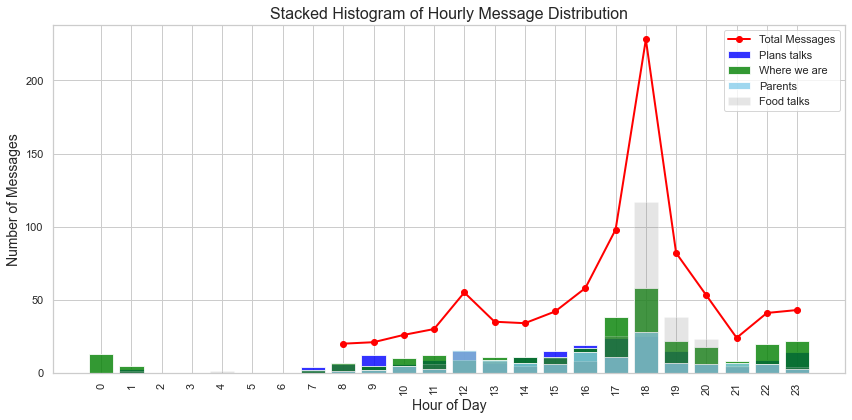

In [468]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is already defined and contains the necessary data
whatsapp_topics = {
    'food': df[df['contains_eten']]['hour'].value_counts().sort_index(),
    'plans': df[df['contains_plans']]['hour'].value_counts().sort_index(),
    'place': df[df['contains_place']]['hour'].value_counts().sort_index(),
    'people': df[df['contains_people']]['hour'].value_counts().sort_index(),
    'parents': df[df['contains_parents']]['hour'].value_counts().sort_index(),
}

# Convert to DataFrames
hour_counts1 = pd.Series(whatsapp_topics['food'])
hour_counts2 = pd.Series(whatsapp_topics['plans'])
hour_counts3 = pd.Series(whatsapp_topics['place'])
hour_counts4 = pd.Series(whatsapp_topics['parents'])

# Create a figure for the histograms
plt.figure(figsize=(12, 6))

# Plotting stacked histograms
plt.bar(hour_counts2.index, hour_counts2.values, color='blue', alpha=0.8, label='Plans talks')
plt.bar(hour_counts3.index, hour_counts3.values, color='green', alpha=0.8, label='Where we are')
plt.bar(hour_counts4.index, hour_counts4.values, color='skyblue', alpha=0.8, label='Parents')
plt.bar(hour_counts1.index, hour_counts1.values, color='gray', alpha=0.2, label='Food talks')

# Add a line representing the total number of messages
total_counts = hour_counts1 + hour_counts2 + hour_counts3 + hour_counts4
plt.plot(total_counts.index, total_counts.values, color='red', marker='o', label='Total Messages', linewidth=2)

# Set the title and labels
plt.title('Stacked Histogram of Hourly Message Distribution', fontsize=16)
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Number of Messages', fontsize=14)

# Set x-ticks to show hours
plt.xticks(range(24), rotation=90)

# Set the y-axis limit for better visibility
plt.ylim(0, max(total_counts.max(), hour_counts1.max(), hour_counts2.max(), hour_counts3.max(), hour_counts4.max()) + 10)

plt.grid(axis='y', visible=True)
plt.legend()  # Add a legend to identify categories
plt.tight_layout()  # Adjust layout for better spacing
plt.show()


<Figure size 864x576 with 0 Axes>

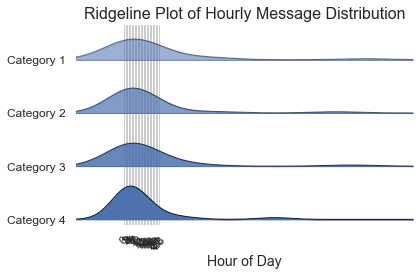

In [403]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joypy import joyplot

# Sample hour distribution data for four categories
data1 = {0: 0, 1: 1, 2: 0, 3: 0, 4: 1,
          5: 0, 6: 0, 7: 2, 8: 6, 9: 4,
          10: 8, 11: 8, 12: 18, 13: 10,
          14: 8, 15: 17, 16: 20, 17: 53,
          18: 160, 19: 58, 20: 26, 21: 9,
          22: 8, 23: 4}

data2 = {0: 1, 1: 2, 2: 1, 3: 1, 4: 0,
          5: 2, 6: 3, 7: 4, 8: 2, 9: 5,
          10: 3, 11: 7, 12: 12, 13: 8,
          14: 6, 15: 10, 16: 12, 17: 20,
          18: 140, 19: 60, 20: 30, 21: 8,
          22: 10, 23: 5}

data3 = {0: 2, 1: 1, 2: 0, 3: 0, 4: 3,
          5: 1, 6: 1, 7: 2, 8: 7, 9: 3,
          10: 6, 11: 8, 12: 10, 13: 6,
          14: 7, 15: 15, 16: 25, 17: 30,
          18: 150, 19: 50, 20: 25, 21: 7,
          22: 5, 23: 2}

data4 = {0: 1, 1: 0, 2: 0, 3: 2, 4: 2,
          5: 0, 6: 1, 7: 1, 8: 4, 9: 2,
          10: 2, 11: 5, 12: 8, 13: 5,
          14: 5, 15: 10, 16: 15, 17: 25,
          18: 100, 19: 40, 20: 20, 21: 5,
          22: 8, 23: 4}

# Convert to DataFrames
hour_counts1 = pd.Series(data1)
hour_counts2 = pd.Series(data2)
hour_counts3 = pd.Series(data3)
hour_counts4 = pd.Series(data4)

# Prepare data for the joyplot
data = [hour_counts1, hour_counts2, hour_counts3, hour_counts4]
labels = ['Category 1', 'Category 2', 'Category 3', 'Category 4']

# Create a figure for the ridgeline plot
plt.figure(figsize=(12, 8))

# Plotting the ridgeline (joyplot)
joyplot(data=data, labels=labels, fade=True, linewidth=1)

# Set the title and labels
plt.title('Ridgeline Plot of Hourly Message Distribution', fontsize=16)
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Categories', fontsize=14)

# Set x-ticks to show hours
plt.xticks(range(24), rotation=45)
# Set the y-axis limit for better visibility
plt.ylim(0, max(hour_counts1.max(), hour_counts2.max(), hour_counts3.max(), hour_counts4.max()) + 10)


# Set y-ticks to show category names
plt.yticks(range(len(labels)), labels)

plt.grid(visible=True)
plt.tight_layout()  # Adjust layout for better spacing
plt.show()



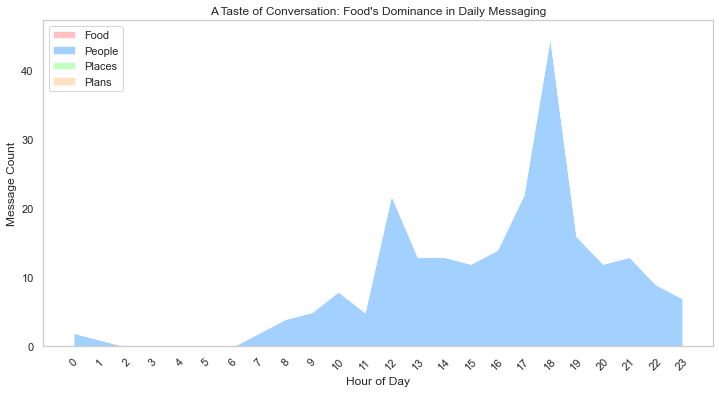

In [495]:
plt.figure(figsize=(12, 6))
# Define custom colors
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']

plt.stackplot(df_counts.index, df_counts.T, colors=colors, labels=df_counts.columns, alpha=0.6)
plt.title("A Taste of Conversation: Food's Dominance in Daily Messaging")
plt.xlabel('Hour of Day')
plt.ylabel('Message Count')
plt.xticks(df_counts.index, rotation=45)
plt.legend(loc='upper left')
plt.grid()
plt.show()

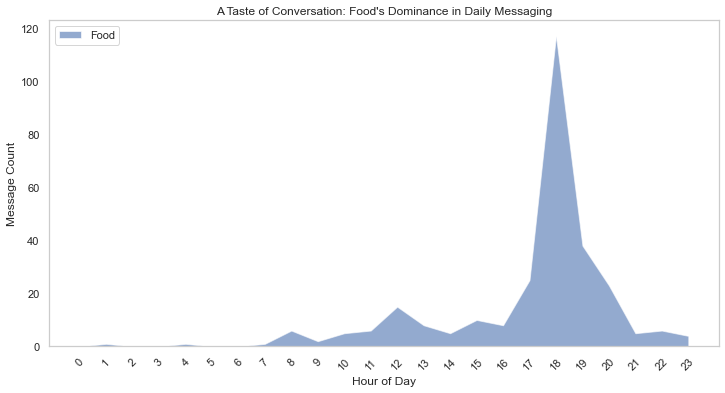

In [479]:
plt.figure(figsize=(12, 6))
plt.stackplot(df_counts.index, df_counts.T, labels=df_counts.columns, alpha=0.6)
plt.title("A Taste of Conversation: Food's Dominance in Daily Messaging")
plt.xlabel('Hour of Day')
plt.ylabel('Message Count')
plt.xticks(df_counts.index, rotation=45)
plt.legend(loc='upper left')
plt.grid()
plt.show()

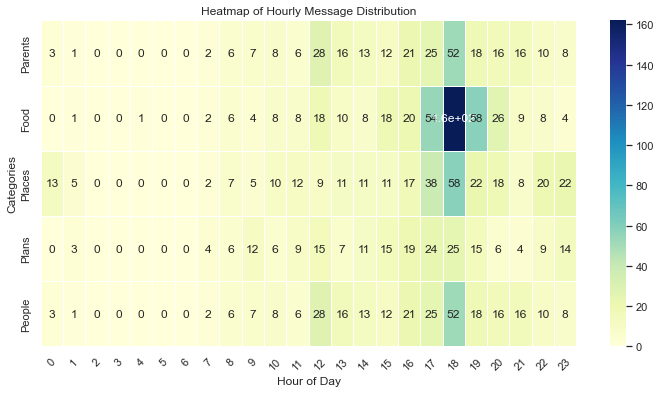

In [437]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.heatmap(df_counts.T, annot=True, cmap='YlGnBu', cbar=True, linewidths=0.5)
plt.title('Heatmap of Hourly Message Distribution')
plt.xlabel('Hour of Day')
plt.ylabel('Categories')
plt.xticks(rotation=45)
plt.show()

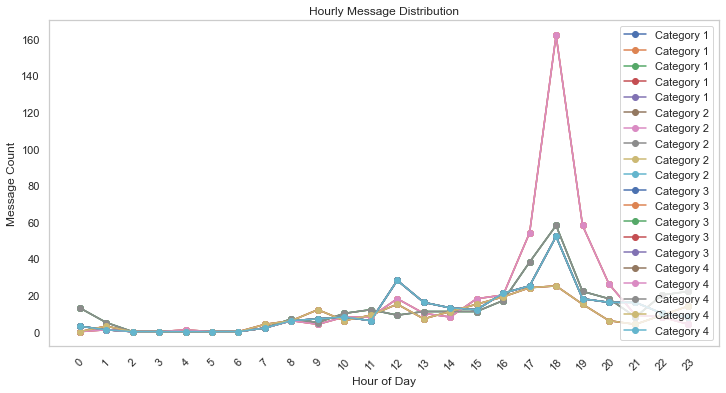

In [440]:
# Data
data = {
    'Category 1': hour_counts1,
    'Category 2': hour_counts2,
    'Category 3': hour_counts3,
    'Category 4': hour_counts4,
}

plt.figure(figsize=(12, 6))

for category, counts in data.items():
    plt.plot(df_counts.index, df_counts.values, marker='o', label=category)

plt.title('Hourly Message Distribution')
plt.xlabel('Hour of Day')
plt.ylabel('Message Count')
plt.xticks(range(24), rotation=45)
plt.legend()
plt.grid()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


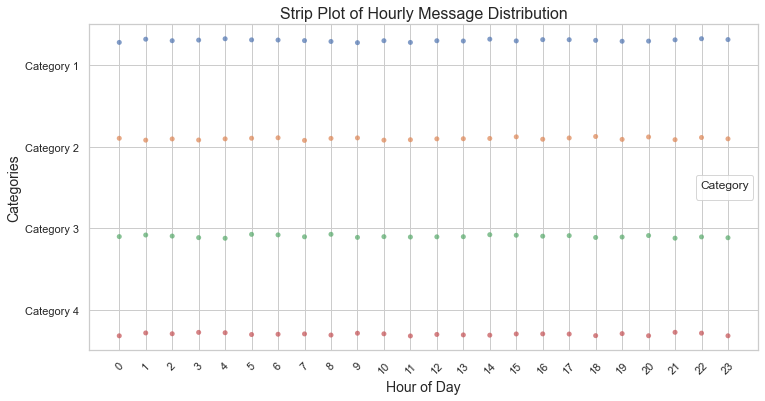

In [456]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample hour distribution data for four categories
data1 = {0: 0, 1: 1, 2: 0, 3: 0, 4: 1,
          5: 0, 6: 0, 7: 2, 8: 6, 9: 4,
          10: 8, 11: 8, 12: 18, 13: 10,
          14: 8, 15: 17, 16: 20, 17: 53,
          18: 160, 19: 58, 20: 26, 21: 9,
          22: 8, 23: 4}

data2 = {0: 1, 1: 2, 2: 1, 3: 1, 4: 0,
          5: 2, 6: 3, 7: 4, 8: 2, 9: 5,
          10: 3, 11: 7, 12: 12, 13: 8,
          14: 6, 15: 10, 16: 12, 17: 20,
          18: 140, 19: 60, 20: 30, 21: 8,
          22: 10, 23: 5}

data3 = {0: 2, 1: 1, 2: 0, 3: 0, 4: 3,
          5: 1, 6: 1, 7: 2, 8: 7, 9: 3,
          10: 6, 11: 8, 12: 10, 13: 6,
          14: 7, 15: 15, 16: 25, 17: 30,
          18: 150, 19: 50, 20: 25, 21: 7,
          22: 5, 23: 2}

data4 = {0: 1, 1: 0, 2: 0, 3: 2, 4: 2,
          5: 0, 6: 1, 7: 1, 8: 4, 9: 2,
          10: 2, 11: 5, 12: 8, 13: 5,
          14: 5, 15: 10, 16: 15, 17: 25,
          18: 100, 19: 40, 20: 20, 21: 5,
          22: 8, 23: 4}

# Convert to DataFrames
hour_counts1 = pd.Series(data1, name='Category 1')
hour_counts2 = pd.Series(data2, name='Category 2')
hour_counts3 = pd.Series(data3, name='Category 3')
hour_counts4 = pd.Series(data4, name='Category 4')

# Create a DataFrame and reindex to ensure all hours are included
df_counts = pd.DataFrame({
    'Category 1': hour_counts1,
    'Category 2': hour_counts2,
    'Category 3': hour_counts3,
    'Category 4': hour_counts4
}).reindex(range(24), fill_value=0)

# Prepare data for strip plot
melted_df = df_counts.reset_index().melt(id_vars='index', 
                                           var_name='Category', 
                                           value_name='Count')
melted_df.rename(columns={'index': 'Hour'}, inplace=True)

# Create the strip plot
plt.figure(figsize=(12, 6))
sns.stripplot(data=melted_df, x='Hour', y='Category', hue='Category', 
               dodge=True, jitter=True, alpha=0.7)

# Set the title and labels
plt.title('Strip Plot of Hourly Message Distribution', fontsize=16)
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Categories', fontsize=14)

plt.xticks(range(24), rotation=45)
plt.legend(title='Category')
plt.grid(visible=True)
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


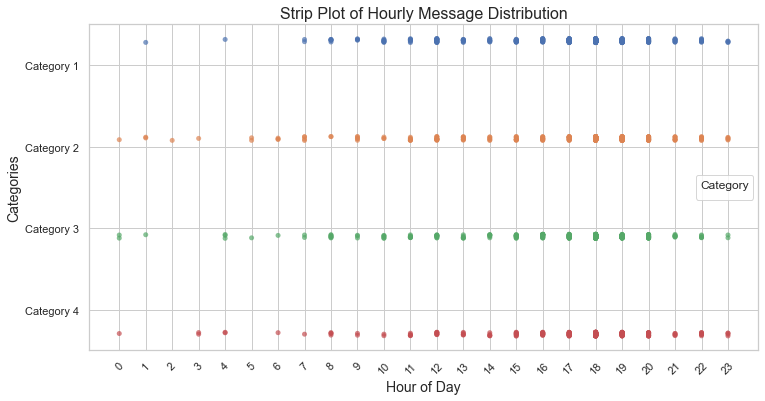

In [457]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample hour distribution data for four categories
data1 = {0: 0, 1: 1, 2: 0, 3: 0, 4: 1,
          5: 0, 6: 0, 7: 2, 8: 6, 9: 4,
          10: 8, 11: 8, 12: 18, 13: 10,
          14: 8, 15: 17, 16: 20, 17: 53,
          18: 160, 19: 58, 20: 26, 21: 9,
          22: 8, 23: 4}

data2 = {0: 1, 1: 2, 2: 1, 3: 1, 4: 0,
          5: 2, 6: 3, 7: 4, 8: 2, 9: 5,
          10: 3, 11: 7, 12: 12, 13: 8,
          14: 6, 15: 10, 16: 12, 17: 20,
          18: 140, 19: 60, 20: 30, 21: 8,
          22: 10, 23: 5}

data3 = {0: 2, 1: 1, 2: 0, 3: 0, 4: 3,
          5: 1, 6: 1, 7: 2, 8: 7, 9: 3,
          10: 6, 11: 8, 12: 10, 13: 6,
          14: 7, 15: 15, 16: 25, 17: 30,
          18: 150, 19: 50, 20: 25, 21: 7,
          22: 5, 23: 2}

data4 = {0: 1, 1: 0, 2: 0, 3: 2, 4: 2,
          5: 0, 6: 1, 7: 1, 8: 4, 9: 2,
          10: 2, 11: 5, 12: 8, 13: 5,
          14: 5, 15: 10, 16: 15, 17: 25,
          18: 100, 19: 40, 20: 20, 21: 5,
          22: 8, 23: 4}

# Create DataFrames for counts
hour_counts1 = pd.Series(data1, name='Category 1')
hour_counts2 = pd.Series(data2, name='Category 2')
hour_counts3 = pd.Series(data3, name='Category 3')
hour_counts4 = pd.Series(data4, name='Category 4')

# Create a DataFrame and reindex to ensure all hours are included
df_counts = pd.DataFrame({
    'Category 1': hour_counts1,
    'Category 2': hour_counts2,
    'Category 3': hour_counts3,
    'Category 4': hour_counts4
}).reindex(range(24), fill_value=0)

# Prepare the data for strip plot by expanding counts into individual entries
def expand_counts(counts, category_name):
    return np.array([[hour, category_name] for hour, count in counts.items() for _ in range(count)])

expanded_data = []
for category in df_counts.columns:
    expanded_data.append(expand_counts(df_counts[category], category))

# Combine the expanded data into a single DataFrame
expanded_array = np.vstack(expanded_data)
expanded_df = pd.DataFrame(expanded_array, columns=['Hour', 'Category'])

# Convert 'Hour' to numeric
expanded_df['Hour'] = expanded_df['Hour'].astype(int)

# Create the strip plot
plt.figure(figsize=(12, 6))
sns.stripplot(data=expanded_df, x='Hour', y='Category', hue='Category',
               dodge=True, jitter=True, alpha=0.7)

# Set the title and labels
plt.title('Strip Plot of Hourly Message Distribution', fontsize=16)
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Categories', fontsize=14)

plt.xticks(range(24), rotation=45)
plt.legend(title='Category')
plt.grid(visible=True)
plt.show()


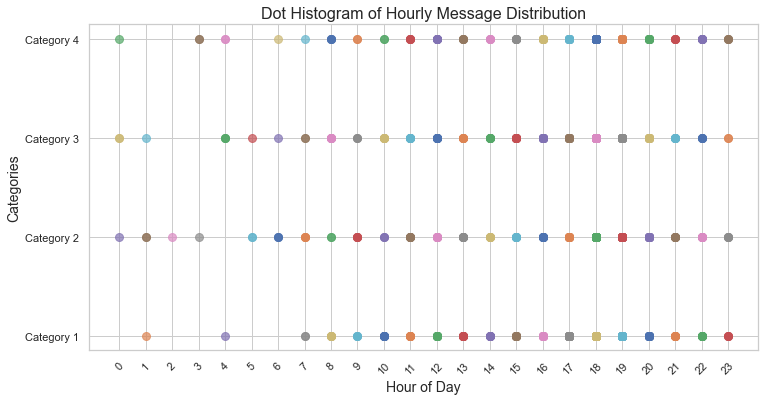

In [458]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sample hour distribution data for four categories
data1 = {0: 0, 1: 1, 2: 0, 3: 0, 4: 1,
          5: 0, 6: 0, 7: 2, 8: 6, 9: 4,
          10: 8, 11: 8, 12: 18, 13: 10,
          14: 8, 15: 17, 16: 20, 17: 53,
          18: 160, 19: 58, 20: 26, 21: 9,
          22: 8, 23: 4}

data2 = {0: 1, 1: 2, 2: 1, 3: 1, 4: 0,
          5: 2, 6: 3, 7: 4, 8: 2, 9: 5,
          10: 3, 11: 7, 12: 12, 13: 8,
          14: 6, 15: 10, 16: 12, 17: 20,
          18: 140, 19: 60, 20: 30, 21: 8,
          22: 10, 23: 5}

data3 = {0: 2, 1: 1, 2: 0, 3: 0, 4: 3,
          5: 1, 6: 1, 7: 2, 8: 7, 9: 3,
          10: 6, 11: 8, 12: 10, 13: 6,
          14: 7, 15: 15, 16: 25, 17: 30,
          18: 150, 19: 50, 20: 25, 21: 7,
          22: 5, 23: 2}

data4 = {0: 1, 1: 0, 2: 0, 3: 2, 4: 2,
          5: 0, 6: 1, 7: 1, 8: 4, 9: 2,
          10: 2, 11: 5, 12: 8, 13: 5,
          14: 5, 15: 10, 16: 15, 17: 25,
          18: 100, 19: 40, 20: 20, 21: 5,
          22: 8, 23: 4}

# Create DataFrames for counts
hour_counts1 = pd.Series(data1, name='Category 1')
hour_counts2 = pd.Series(data2, name='Category 2')
hour_counts3 = pd.Series(data3, name='Category 3')
hour_counts4 = pd.Series(data4, name='Category 4')

# Create a DataFrame and reindex to ensure all hours are included
df_counts = pd.DataFrame({
    'Category 1': hour_counts1,
    'Category 2': hour_counts2,
    'Category 3': hour_counts3,
    'Category 4': hour_counts4
}).reindex(range(24), fill_value=0)

# Create a figure for the dot histogram
plt.figure(figsize=(12, 6))

# Iterate through each category and plot dots
for idx, category in enumerate(df_counts.columns):
    for hour, count in df_counts[category].items():
        plt.plot([hour] * count, [idx] * count, 'o', markersize=8, alpha=0.7)

# Set the title and labels
plt.title('Dot Histogram of Hourly Message Distribution', fontsize=16)
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Categories', fontsize=14)

# Set y-ticks to show category names
plt.yticks(range(len(df_counts.columns)), df_counts.columns)

plt.xticks(range(24), rotation=45)
plt.grid(visible=True)
plt.show()


In [464]:
df[df['contains_eten']]['hour'].value_counts().sort_index()
df_counts

,Food,Places,Plans
0,0.0,13.0,0.0
1,1.0,5.0,3.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,1.0,0.0,0.0
5,0.0,0.0,0.0
6,0.0,0.0,0.0
7,1.0,2.0,4.0
8,6.0,7.0,6.0
9,2.0,5.0,12.0


In [460]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample hour distribution data for four categories
data1 = {0: 0, 1: 1, 2: 0, 3: 0, 4: 1,
          5: 0, 6: 0, 7: 2, 8: 6, 9: 4,
          10: 8, 11: 8, 12: 18, 13: 10,
          14: 8, 15: 17, 16: 20, 17: 53,
          18: 160, 19: 58, 20: 26, 21: 9,
          22: 8, 23: 4}

data2 = {0: 1, 1: 2, 2: 1, 3: 1, 4: 0,
          5: 2, 6: 3, 7: 4, 8: 2, 9: 5,
          10: 3, 11: 7, 12: 12, 13: 8,
          14: 6, 15: 10, 16: 12, 17: 20,
          18: 140, 19: 60, 20: 30, 21: 8,
          22: 10, 23: 5}

data3 = {0: 2, 1: 1, 2: 0, 3: 0, 4: 3,
          5: 1, 6: 1, 7: 2, 8: 7, 9: 3,
          10: 6, 11: 8, 12: 10, 13: 6,
          14: 7, 15: 15, 16: 25, 17: 30,
          18: 150, 19: 50, 20: 25, 21: 7,
          22: 5, 23: 2}

data4 = {0: 1, 1: 0, 2: 0, 3: 2, 4: 2,
          5: 0, 6: 1, 7: 1, 8: 4, 9: 2,
          10: 2, 11: 5, 12: 8, 13: 5,
          14: 5, 15: 10, 16: 15, 17: 25,
          18: 100, 19: 40, 20: 20, 21: 5,
          22: 8, 23: 4}

# Create DataFrames for counts
hour_counts1 = pd.Series(data1, name='Category 1')
hour_counts2 = pd.Series(data2, name='Category 2')
hour_counts3 = pd.Series(data3, name='Category 3')
hour_counts4 = pd.Series(data4, name='Category 4')

# Create a DataFrame and reindex to ensure all hours are included
df_counts = pd.DataFrame({
    'Category 1': hour_counts1,
    'Category 2': hour_counts2,
    'Category 3': hour_counts3,
    'Category 4': hour_counts4
}).reindex(range(24), fill_value=0)

whatsapp_topics = {
    'food': int(df[df['contains_eten']]['hour']).value_counts().sort_index(),
    'plans': df[df['contains_plans']]['hour'].value_counts().sort_index(),
    'place': df[df['contains_place']]['hour'].value_counts().sort_index(),
    'people': df[df['contains_people']]['hour'].value_counts().sort_index(),
    'parents':df[df['contains_parents']]['hour'].value_counts().sort_index(),
    'mama':df[df['contains_mama']]['hour'].value_counts().sort_index(),
    'papa':df[df['contains_papa']]['hour'].value_counts().sort_index(),
         }

# Convert to DataFrames
hour_counts1 = pd.Series(whatsapp_topics['food'])
hour_counts2 = pd.Series(whatsapp_topics['plans'])
hour_counts3 = pd.Series(whatsapp_topics['place'])
hour_counts4 = pd.Series(whatsapp_topics['people'])
hour_counts5 = pd.Series(whatsapp_topics['parents'])
hour_counts6 = pd.Series(whatsapp_topics['mama'])
hour_counts7 = pd.Series(whatsapp_topics['papa'])

# Convert to DataFrames
hour_counts1 = pd.Series(whatsapp_topics['food'], name='Food')
hour_counts2 = pd.Series(whatsapp_topics['plans'], name='Plans')
hour_counts3 = pd.Series(whatsapp_topics['place'], name='Places')
hour_counts4 = pd.Series(whatsapp_topics['people'], name='People')
hour_counts5 = pd.Series(whatsapp_topics['people'], name='Parents')
hour_counts6 = pd.Series(whatsapp_topics['mama'], name='Mama')
hour_counts7 = pd.Series(whatsapp_topics['papa'], name='Papa')

# Create a DataFrame and reindex to ensure all hours are included
df_counts = pd.DataFrame({
    #'Parents': hour_counts5,
    'Food': hour_counts1,
    'Places': hour_counts3,
    'Plans': hour_counts2,
    #'People': hour_counts4,
    #'Mama': hour_counts5,
    #'Papa': hour_counts5,
}).fillna(0).reindex(range(24), fill_value=0)

print(df_counts)  # Check the aligned DataFrame

# Prepare the data for beeswarm plot by expanding counts into individual entries
def expand_counts(counts, category_name):
    return np.array([[hour, category_name] for hour, count in counts.items() for _ in range(count)])

expanded_data = []
for category in df_counts.columns:
    expanded_data.append(expand_counts(df_counts[category], category))

# Combine the expanded data into a single DataFrame
expanded_array = np.vstack(expanded_data)
expanded_df = pd.DataFrame(expanded_array, columns=['Hour', 'Category'])

# Convert 'Hour' to numeric
expanded_df['Hour'] = expanded_df['Hour'].astype(int)

# Create the beeswarm plot
plt.figure(figsize=(12, 6))
sns.swarmplot(data=expanded_df, x='Hour', y='Category', hue='Category', dodge=True, alpha=0.7)

# Set the title and labels
plt.title('Beeswarm Plot of Hourly Message Distribution', fontsize=16)
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Categories', fontsize=14)

plt.xticks(range(24), rotation=45)
plt.legend(title='Category')
plt.grid(visible=True)
plt.show()


     Food  Places  Plans
0     0.0    13.0    0.0
1     1.0     5.0    3.0
2     0.0     0.0    0.0
3     0.0     0.0    0.0
4     1.0     0.0    0.0
5     0.0     0.0    0.0
6     0.0     0.0    0.0
7     1.0     2.0    4.0
8     6.0     7.0    6.0
9     2.0     5.0   12.0
10    5.0    10.0    6.0
11    6.0    12.0    9.0
12   15.0     9.0   15.0
13    8.0    11.0    7.0
14    5.0    11.0   11.0
15   10.0    11.0   15.0
16    8.0    17.0   19.0
17   25.0    38.0   24.0
18  117.0    58.0   25.0
19   38.0    22.0   15.0
20   23.0    18.0    6.0
21    5.0     8.0    4.0
22    6.0    20.0    9.0
23    4.0    22.0   14.0


TypeError: 'float' object cannot be interpreted as an integer

c:\installaties\miniconda3\lib\site-packages\seaborn\distributions.py:413: UserWarning: `bins` cannot be 'auto' when using weights. Setting `bins=10`, but you will likely want to adjust.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


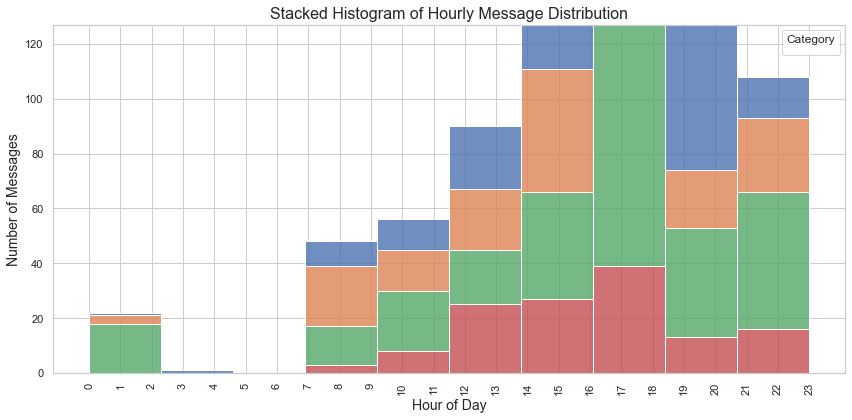

In [470]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is already defined and contains the necessary data
whatsapp_topics = {
    'food': df[df['contains_eten']]['hour'].value_counts().sort_index(),
    'plans': df[df['contains_plans']]['hour'].value_counts().sort_index(),
    'place': df[df['contains_place']]['hour'].value_counts().sort_index(),
    'parents': df[df['contains_parents']]['hour'].value_counts().sort_index(),
}

# Create a complete hour index
hours = np.arange(24)

# Reindex each category to ensure they all have the same length
hour_counts1 = whatsapp_topics['food'].reindex(hours, fill_value=0)
hour_counts2 = whatsapp_topics['plans'].reindex(hours, fill_value=0)
hour_counts3 = whatsapp_topics['place'].reindex(hours, fill_value=0)
hour_counts4 = whatsapp_topics['parents'].reindex(hours, fill_value=0)

# Create a DataFrame for each category to use with sns.histplot
df_hist = pd.DataFrame({
    'Hour': np.tile(hours, 4),
    'Counts': np.concatenate([hour_counts1.values, hour_counts2.values, hour_counts3.values, hour_counts4.values]),
    'Category': ['Food'] * 24 + ['Plans'] * 24 + ['Place'] * 24 + ['Parents'] * 24
})

# Create a figure for the histograms
plt.figure(figsize=(12, 6))

# Plotting with sns.histplot
sns.histplot(data=df_hist, x='Hour', weights='Counts', hue='Category', multiple='stack', alpha=0.8)

# Set the title and labels
plt.title('Stacked Histogram of Hourly Message Distribution', fontsize=16)
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Number of Messages', fontsize=14)

# Set x-ticks to show hours
plt.xticks(range(24), rotation=90)

# Set the y-axis limit for better visibility
plt.ylim(0, df_hist['Counts'].max() + 10)

plt.grid(axis='y', visible=True)
plt.legend(title='Category')  # Add a legend to identify categories
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

